# DELE CA2 Part B
### Reinforcement Learning
Ng Yan Jie<br>
P2128818<br>
DAAAFT2B03<br><br>

Yek Yi Wei<br>
P2107631<br>
DAAAFT2B03

## Background Information
### Lunar Lander Dataset
The Lunar Lander dataset is a simulation of a lunar landing mission, used as an example reinforcement learning task.<br><br>

The objective of the task is to safely land a lunar lander spacecraft on the surface of the moon. The state space of the task consists of the X, Y coordinates of the lander, its velocity, angle, and angular velocity, and the actions available are the main engine thrust in two directions (left/right, up/down).<br><br>

The reward function for this task is designed such that landing the lunar lander safely results in a large positive reward, whereas crashing results in a large negative reward.<br><br>

The Lunar Lander dataset is a classic example in Reinforcement Learning (RL) and was not created by any specific individual or organization. It has been widely used as a benchmark problem in the RL community for many years and has been implemented in various RL libraries and platforms, such as OpenAI Gym, Unity ML-Agents, etc. The task and its associated rules are well-established in the RL community and have been used as a benchmark in many research papers and articles.<br><br>

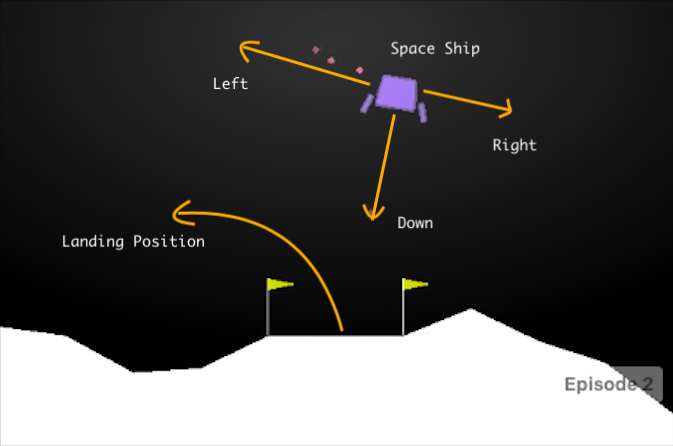

Dataset from https://gym.openai.com/envs/LunarLander-v2/
<br><br><br>
### Reinforcement Learning
Reinforcement Learning is a type of machine learning where an agent learns to make decisions by performing actions and observing the rewards it receives. The goal is to learn a policy that maximizes the cumulative reward over time.<br><br>

The process involves the agent taking actions in an environment, receiving feedback in the form of rewards or penalties, and updating its understanding of the relationship between its actions and the received rewards. This learning process continues iteratively until the agent converges on an optimal policy that maximizes the reward.<br><br>

Reinforcement learning has been applied to a variety of problems, including game playing, robotics, and recommendation systems.

## Objective
Apply a suitable RL architecture to the problem. Land the LunarLander successfully on the landing pad.

After doing our research, we found that DQN is sufficient even though it is a veryt simple and basic model. This is because the Lunar Lander task is relatively simple and does not require an extremely smart model.

## Import Libraries

In [ ]:
### SKIP IF ALREADY INSTALLED ###
pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [1]:
import gym
import numpy as np
import pandas as pd
from collections import deque
import random

from keras import Sequential
from keras.layers import Dense
from keras.activations import relu, linear
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.models import load_model

import pickle
from matplotlib import pyplot as plt

## DQN
Deep Q-Network (DQN) is a deep reinforcement learning algorithm developed by DeepMind in 2015.<br><br>

It combines a deep neural network with reinforcement learning to learn the optimal action-value function, which maps states to the expected reward for each possible action. The algorithm uses experience replay to store and learn from previous experiences, and also employs a target network to stabilize the learning process.<br><br>

DQN has been successfully applied to a variety of Atari games, achieving superhuman performance in many of them. The algorithm and its variants have also been used in other domains such as robotics and autonomous driving.<br><br>

#### Model Architecture
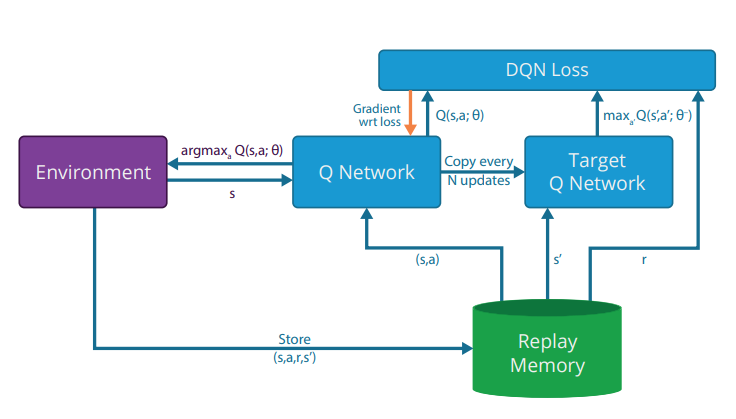

Using DQN has the following advantages!
> - End-to-end learning: DQN can learn directly from raw sensory inputs, such as image frames or sensor readings, to control an agent in a complex environment. This eliminates the need for hand-engineered features or reward functions.
- Model-free learning: DQN is a model-free method, meaning it does not require knowledge of the environment's dynamics or a model of the transition probabilities between states. This makes it well-suited for problems where it is difficult or infeasible to model the environment.
- High sample efficiency: DQN can learn effectively from relatively few interactions with the environment, making it suitable for problems where data collection is expensive or time-consuming.
- Generalization: DQN can generalize from previous experiences to new situations, allowing it to quickly adapt to changing environments or to new tasks.
- Online learning: DQN can learn online, meaning it can continuously improve its performance as it interacts with the environment, without the need for retraining from scratch.
- Parallelization: DQN can be easily parallelized to scale up to large or high-dimensional problems, making it a good choice for problems with a large number of possible actions or states.

<br>

More information can be found at https://www.nature.com/articles/nature14236.pdf

In [ ]:
class DQN:
    def __init__(self, env, lr, gamma, epsilon, epsilon_decay):
        self.env = env
        self.action_space = env.action_space
        self.observation_space = env.observation_space
        self.counter = 0

        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.rewards_list = []

        self.replay_memory_buffer = deque(maxlen=500000)
        self.batch_size = 64
        self.epsilon_min = 0.01
        self.num_action_space = self.action_space.n
        self.num_observation_space = env.observation_space.shape[0]
        self.model = self.initialize_model()

    def initialize_model(self):
        ## Build model
        model = Sequential()
        model.add(Dense(512, input_dim=self.num_observation_space, activation=relu))
        model.add(Dense(256, activation=relu))
        model.add(Dense(self.num_action_space, activation=linear))

        ## Compile model
        model.compile(loss=mean_squared_error,optimizer=Adam(lr=self.lr))
        print(model.summary())
        return model

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.num_action_space)

        predicted_actions = self.model.predict(state)
        return np.argmax(predicted_actions[0])

    def add_to_replay_memory(self, state, action, reward, next_state, done):
        self.replay_memory_buffer.append((state, action, reward, next_state, done))

    def learn_and_update_weights_by_reply(self):
        ## replay_memory_buffer size check
        if len(self.replay_memory_buffer) < self.batch_size or self.counter != 0:
            return

        ## Early Stopping
        if np.mean(self.rewards_list[-10:]) > 180:
            return

        random_sample = self.get_random_sample_from_replay_mem()
        states, actions, rewards, next_states, done_list = self.get_attribues_from_sample(random_sample)
        targets = rewards + self.gamma * (np.amax(self.model.predict_on_batch(next_states), axis=1)) * (1 - done_list)
        target_vec = self.model.predict_on_batch(states)
        indexes = np.array([i for i in range(self.batch_size)])
        target_vec[[indexes], [actions]] = targets

        self.model.fit(states, target_vec, epochs=1, verbose=0)


    def get_attribues_from_sample(self, random_sample):
        states = np.array([i[0] for i in random_sample])
        actions = np.array([i[1] for i in random_sample])
        rewards = np.array([i[2] for i in random_sample])
        next_states = np.array([i[3] for i in random_sample])
        done_list = np.array([i[4] for i in random_sample])
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        return np.squeeze(states), actions, rewards, next_states, done_list

    def get_random_sample_from_replay_mem(self):
        random_sample = random.sample(self.replay_memory_buffer, self.batch_size)
        return random_sample

    def train(self, num_episodes=2000, can_stop=True):

        for episode in range(num_episodes):
            state = env.reset()
            reward_for_episode = 0
            num_steps = 1000
            state = np.reshape(state, [1, self.num_observation_space])
            for step in range(num_steps):
                env.render()
                received_action = self.get_action(state)
                # print("received_action:", received_action)
                next_state, reward, done, info = env.step(received_action)
                next_state = np.reshape(next_state, [1, self.num_observation_space])
                ## Store the experience in replay memory
                self.add_to_replay_memory(state, received_action, reward, next_state, done)
                ## Add up rewards
                reward_for_episode += reward
                state = next_state
                self.update_counter()
                self.learn_and_update_weights_by_reply()

                if done:
                    break
            self.rewards_list.append(reward_for_episode)

            ## Decay the epsilon after each experience completion
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            ## Check break condition
            last_rewards_mean = np.mean(self.rewards_list[-100:])
            if last_rewards_mean > 250 and can_stop:
                print("DQN Training Complete...")
                self.model.save(f"Fully Trained.h5")
                break
            print(episode, "\t: Episode || Reward: ",reward_for_episode, "\t|| Average Reward: ",last_rewards_mean, "\t epsilon: ", self.epsilon )

            if episode % 25 == 0:
                self.model.save(f"episode-{episode}.h5")


    def update_counter(self):
        self.counter += 1
        step_size = 5
        self.counter = self.counter % step_size

    def save(self, name):
        self.model.save(name)

## Training
1. Environment simulation: The first step is to simulate an environment that the agent will interact with. This environment should be defined by a set of states, actions, and rewards, and the dynamics of the environment should be defined by a set of transition probabilities between states.
2. Initialization: Initialize the neural network architecture for the Q-function, the replay buffer, and other hyperparameters such as the learning rate, discount factor, and exploration strategy.
3. Experience collection: The agent interacts with the environment, and the resulting experiences, in the form of (state, action, reward, next state) tuples, are stored in the replay buffer.
4. Training: The agent periodically samples a batch of experiences from the replay buffer and updates the Q-function parameters using stochastic gradient descent and a loss function that measures the difference between the predicted Q-value and the target Q-value.
5. Target network updates: To stabilize the training, a separate "target" Q-function is used to compute the target Q-values, which are used to update the Q-function. The target Q-function is updated periodically to track the Q-function.
6. Exploration-exploitation: During training, the agent should balance exploration, where it selects actions randomly to explore the state space, with exploitation, where it selects actions based on the current Q-function to maximize the expected reward. This can be achieved using epsilon-greedy exploration, where the agent selects actions randomly with probability epsilon, and selects the action with the highest Q-value with probability (1 - epsilon).
7. Repeat: Repeat the process of experience collection, training, and target network updates until the Q-function has converged to a satisfactory level, which in this case, we set to <b>250</b>.



In [ ]:
## Init env
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [ ]:
env = gym.make('LunarLander-v2')

## Setting up params
lr = 0.001
epsilon = 1.0
epsilon_decay = 0.995
gamma = 0.99
training_episodes = 2000

model = DQN(env, lr, gamma, epsilon, epsilon_decay)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 dense (Dense)               (None, 512)               4608      
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 136,964
Trainable params: 136,964
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
%%time
model.train(training_episodes, True)

/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step
400 	: Episode || Reward:  173.32277339521806 	|| Average Reward:  230.1660640205245 	 epsilon:  0.13398475271138335
1/1 [==============================] - 0s 22ms/step
401 	: Episode || Reward:  225.9804086629902 	|| Average Reward:  234.35145844527074 	 epsilon:  0.13331482894782642
1/1 [==============================] - 0s 33ms/step
402 	: Episode || Reward:  248.23046828823183 	|| Average Reward:  235.31295667877035 	 epsilon:  0.13264825480308728
1/1 [==============================] - 0s 21ms/step
403 	: Episode || Reward:  294.53359757342906 	|| Average Reward:  237.58268251143247 	 epsilon:  0.13198501352907185
1/1 [==============================] - 0s 16ms/step
404 	: Episode || Reward:  270.3102250203011 	|| Average Reward:  238.91035866740953 	 epsilon:  0.1313250884614265
1/1 [==============================] - 0s 21ms/step
405 	: Episode || Reward:  274.51641940932285 	|| A

Training ended after episode 416!

Time to evaluate our model.

## Evaluation
Evaluation is based on average episodic rewards

In [ ]:
def plot_df(df, chart_name, title, x_axis_label, y_axis_label):
    ## This function plots the episodic and average reward on a line graph
    plt.rcParams.update({'font.size': 17})
    df['rolling_mean'] = df[df.columns[0]].rolling(100).mean()
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    plot = df.plot(linewidth=1.5, figsize=(15, 8))
    plt.plot([250 for i in range(df.shape[0])], '--') ## Target line (250)
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    plt.title(title)

    fig = plot.get_figure()
    plt.legend().set_visible(False)
    fig.savefig(chart_name)

    plt.show()

In [ ]:
## Save Rewards list
pickle.dump(model.rewards_list, open("train_rewards_list.p", "wb"))
rewards_list = pickle.load(open("train_rewards_list.p", "rb"))

<Figure size 432x288 with 0 Axes>

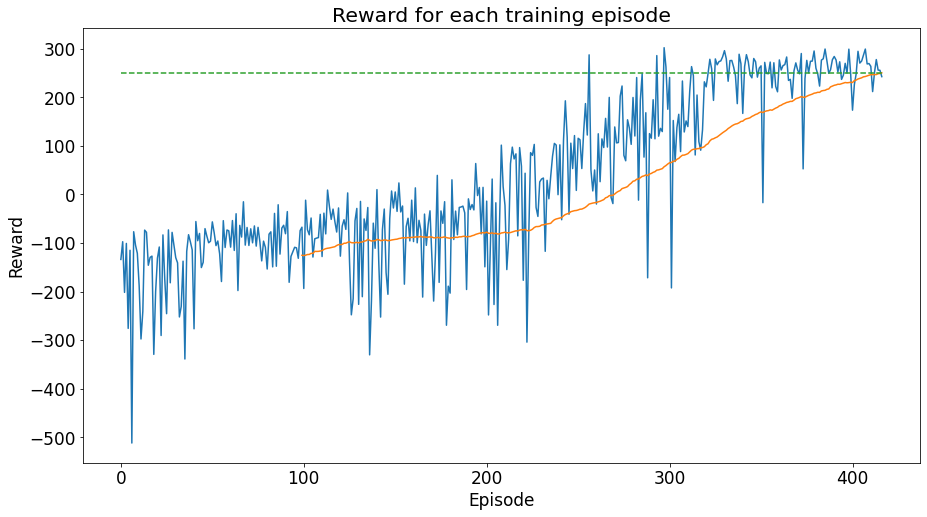

In [ ]:
## Plot reward in graph
reward_df = pd.DataFrame(rewards_list)
plot_df(reward_df, "Fig 1: Reward for each training episode", "Reward for each training episode", "Episode","Reward")

## Test
1. Create a testing environment, either real or simulated, that can provide observations and rewards to the agent.
2. Load the pre-trained DQN model into the environment.
3. Run the agent in the environment and let it act according to the learned policy, collecting data on its performance (e.g., average rewards, success rate, etc.).
4. Evaluate the collected data and compare it to the desired performance metrics.
5. Repeat the testing process multiple times and average the results to obtain a more robust evaluation of the agent's performance.<br><br>

Note that it is important for the testing environment to be different from the training environment. This ensures that the agent has not memorized the training data and is able to generalize to new situations.

In [5]:
def plot_df2(df, chart_name, title, x_axis_label, y_axis_label):
    ## This function plots the episodic and average reward on a line graph
    df['mean'] = df[df.columns[0]].mean()
    plt.rcParams.update({'font.size': 17})
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    plot = df.plot(linewidth=1.5, figsize=(15, 8))
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    plt.title(title)
    plt.plot([250 for i in range(df.shape[0])], '--') ## Target line (250)
    plt.legend().set_visible(False)
    fig = plot.get_figure()
    fig.savefig(chart_name)

In [6]:
def test_already_trained_model(trained_model):
    rewards_list = []
    num_test_episode = 1000
    env = gym.make("LunarLander-v2")
    print("Starting Testing of the trained model...")

    step_count = 1000

    for test_episode in range(num_test_episode):
        current_state = env.reset()
        num_observation_space = env.observation_space.shape[0]
        current_state = np.reshape(current_state, [1, num_observation_space])
        reward_for_episode = 0
        for step in range(step_count):
            env.render()
            selected_action = np.argmax(trained_model.predict(current_state)[0])
            new_state, reward, done, info = env.step(selected_action)
            new_state = np.reshape(new_state, [1, num_observation_space])
            current_state = new_state
            reward_for_episode += reward
            if done:
                break
        rewards_list.append(reward_for_episode)
        print(test_episode, "\t: Episode || Reward: ", reward_for_episode)

    return rewards_list

In [ ]:
trained_model = load_model("Fully Trained.h5")
test_rewards = test_already_trained_model(trained_model)

Starting Testing of the trained model...
1/1 [==============================] - 0s 15ms/step


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't 

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step
982 	: Episode || Reward:  286.8330883852741
1/1 [==============================] - 0s 17ms/step
983 	: Episode || Reward:  254.52087335783372
1/1 [==============================] - 0s 41ms/step
984 	: Episode || Reward:  276.39937736494824
1/1 [==============================] - 0s 22ms/step
985 	: Episode || Reward:  263.49482028615495
1/1 [==============================] - 0s 16ms/step
986 	: Episode || Reward:  246.88478051429647
1/1 [==============================] - 0s 15ms/step
987 	: Episode || Reward:  263.6535854714071
1/1 [==============================] - 0s 16ms/step
988 	: Episode || Reward:  287.58075318760154
1/1 [==============================] - 0s 16ms/step
989 	: Episode || Reward:  269.2360633668162
1/1 [==============================] - 0s 24ms/step
990 	: Episode || Reward:  233.96997635222027
1/1 [==============================] - 0s 16ms/step
991 	: Episode || 

In [7]:
## Save rewards list
pickle.dump(test_rewards, open("test_rewards.p", "wb"))
test_rewards = pickle.load(open("test_rewards.p", "rb"))

Training and Testing Completed...!


<Figure size 432x288 with 0 Axes>

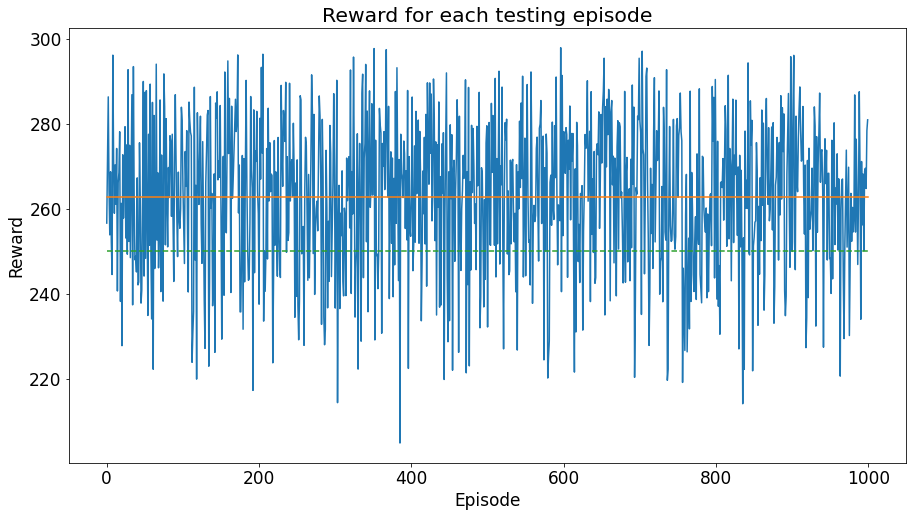

In [8]:
## Plot reward in graph
test_rewards_df = pd.DataFrame(test_rewards)
plot_df2(test_rewards_df, "Fig 2: Reward for each testing episode",
         "Reward for each testing episode", "Episode", "Reward")
print("Training and Testing Completed...!")

In [10]:
print("General Statistics")
print(f'Average reward: {test_rewards_df[0].mean()}\nMedian reward: {test_rewards_df[0].median()}')
print(f'Stdev: {test_rewards_df[0].std()}')

## Calculate failure and success instances
crash = len(test_rewards_df[test_rewards_df[0]<=200])
land = len(test_rewards_df[test_rewards_df[0]>200])
print(f'Instances of failure: {crash} ({crash/land*100}%)')
print(f'Instances of success: {land} ({(land-crash)/land*100}%)')

General Statistics
Average reward: 262.81452310105607
Median reward: 265.01742947239387
Stdev: 17.830123755591195
Instances of failure: 0 (0.0%)
Instances of success: 1000 (100.0%)


Taking into account that the reward score for a successful landing is 100, the DQN model was able to achieve 100% success rate in 1000 trials!

## Tune hyperparameters
We had initially planned to tune the hyperparameters <i>gamma</i>, <i>learning rate</i>, and <i>epsilon decay</i>.<br><br>

However, considering that fact that our model was able to excel the task by getting an average reward score of 250 with just 416 episodes, and time constraint, we then decided to drop the idea of hypertuning. 

In [ ]:
def plot_experiments(df, chart_name, title, x_axis_label, y_axis_label, y_limit):
    plt.rcParams.update({'font.size': 17})
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    plot = df.plot(linewidth=1, figsize=(15, 8), title=title)
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    plt.ylim(y_limit)
    fig = plot.get_figure()
    fig.savefig(chart_name)

In [ ]:
def run_experiment_for_gamma():
    print('Running Experiment for gamma...')
    env = gym.make('LunarLander-v2')

    ## Set seeds
    env.seed(21)
    np.random.seed(21)

    ## Setting up params
    lr = 0.001
    epsilon = 1.0
    epsilon_decay = 0.995
    gamma_list = [0.99, 0.9, 0.8, 0.7]
    training_episodes = 1000

    rewards_list_for_gammas = []
    for gamma_value in gamma_list:
        model = DQN(env, lr, gamma_value, epsilon, epsilon_decay)
        print("Training model for Gamma: {}".format(gamma_value))
        model.train(training_episodes, False)
        rewards_list_for_gammas.append(model.rewards_list)

    pickle.dump(rewards_list_for_gammas, open("rewards_list_for_gammas.p", "wb"))
    rewards_list_for_gammas = pickle.load(open("rewards_list_for_gammas.p", "rb"))

    gamma_rewards_pd = pd.DataFrame(index=pd.Series(range(1, training_episodes + 1)))
    for i in range(len(gamma_list)):
        col_name = "gamma=" + str(gamma_list[i])
        gamma_rewards_pd[col_name] = rewards_list_for_gammas[i]
    plot_experiments(gamma_rewards_pd, "Fig 3: Rewards per episode for different gamma values",
                     "Rewards per episode for different gamma values", "Episodes", "Reward", (-600, 300))

In [ ]:
def run_experiment_for_lr():
    print('Running Experiment for learning rate...')
    env = gym.make('LunarLander-v2')

    ## Set seeds
    env.seed(21)
    np.random.seed(21)

    ## Setting up params
    lr_values = [0.0001, 0.001, 0.01, 0.1]
    epsilon = 1.0
    epsilon_decay = 0.995
    gamma = 0.99
    training_episodes = 1000
    rewards_list_for_lrs = []
    for lr_value in lr_values:
        model = DQN(env, lr_value, gamma, epsilon, epsilon_decay)
        print("Training model for LR: {}".format(lr_value))
        model.train(training_episodes, False)
        rewards_list_for_lrs.append(model.rewards_list)

    pickle.dump(rewards_list_for_lrs, open("rewards_list_for_lrs.p", "wb"))
    rewards_list_for_lrs = pickle.load(open("rewards_list_for_lrs.p", "rb"))

    lr_rewards_pd = pd.DataFrame(index=pd.Series(range(1, training_episodes + 1)))
    for i in range(len(lr_values)):
        col_name = "lr="+ str(lr_values[i])
        lr_rewards_pd[col_name] = rewards_list_for_lrs[i]
    plot_experiments(lr_rewards_pd, "Fig 4: Rewards per episode for different learning rates",
                     "Rewards per episode for different learning rates", "Episodes", "Reward", (-2000, 300))

In [ ]:
def run_experiment_for_ed():
    print('Running Experiment for epsilon decay...')
    env = gym.make('LunarLander-v2')

    ## Set seeds
    env.seed(42)
    np.random.seed(42)

    ## Setting up params
    lr = 0.001
    epsilon = 1.0
    ed_values = [0.999, 0.995, 0.990, 0.9]
    gamma = 0.99
    training_episodes = 1000

    rewards_list_for_ed = []
    for ed in ed_values:
        model = DQN(env, lr, gamma, epsilon, ed)
        print("Training model for ED: {}".format(ed))
        model.train(training_episodes, False)
        rewards_list_for_ed.append(model.rewards_list)

    pickle.dump(rewards_list_for_ed, open("rewards_list_for_ed.p", "wb"))
    rewards_list_for_ed = pickle.load(open("rewards_list_for_ed.p", "rb"))

    ed_rewards_pd = pd.DataFrame(index=pd.Series(range(1, training_episodes+1)))
    for i in range(len(ed_values)):
        col_name = "epsilon_decay = "+ str(ed_values[i])
        ed_rewards_pd[col_name] = rewards_list_for_ed[i]
    plot_experiments(ed_rewards_pd, "Fig 5: Rewards per episode for different epsilon(ε) decay",
                     "Rewards per episode for different epsilon(ε) decay values", "Episodes", "Reward", (-600, 300))

In [ ]:
## Run experiments for hypertuning
run_experiment_for_lr()
run_experiment_for_ed()
run_experiment_for_gamma()

## Conclusion
We have met the requirements of this task. Given more time, we would have further developed this model into DDQN and D3QN.

We also wanted to try models with the<i>actor-critic</i> architecture such as AC, A2C, PPO, and TRPO. However, we had to keep in mind the nature of the difficulty of this task, which does not require such complex algorithms to be able to ace the task.